# Whale stalker, whale saver
Explanatory data analsysis for the dataset of the challenge

In [59]:
import os
import pandas as pd
import cv2
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image

In [106]:
data_folder = os.path.join('..', 'data/')
img_train_path = os.path.abspath(data_folder+'train')
img_test_path = os.path.abspath(data_folder+'test')
csv_train_path = os.path.abspath(data_folder+'train.csv')

df = pd.read_csv(csv_train_path)
# create image path to simplify the image reading process 
df['Image_path'] = [os.path.join(img_train_path,whale) for whale in df['Image']]

In [117]:
print(f"Number of images: {df.shape[0]}")
print(f"Number of unique species: {df.Id.nunique()}")
print(df.head())
df.Id.value_counts().head()

Number of images: 25361
Number of unique species: 5005
           Image         Id                                         Image_path
0  0000e88ab.jpg  w_f48451c  /Users/rachaelsaxby/Desktop/fg-hackathon/kaggl...
1  0001f9222.jpg  w_c3d896a  /Users/rachaelsaxby/Desktop/fg-hackathon/kaggl...
2  00029d126.jpg  w_20df2c5  /Users/rachaelsaxby/Desktop/fg-hackathon/kaggl...
3  00050a15a.jpg  new_whale  /Users/rachaelsaxby/Desktop/fg-hackathon/kaggl...
4  0005c1ef8.jpg  new_whale  /Users/rachaelsaxby/Desktop/fg-hackathon/kaggl...


new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

## Display a few samples

In [80]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

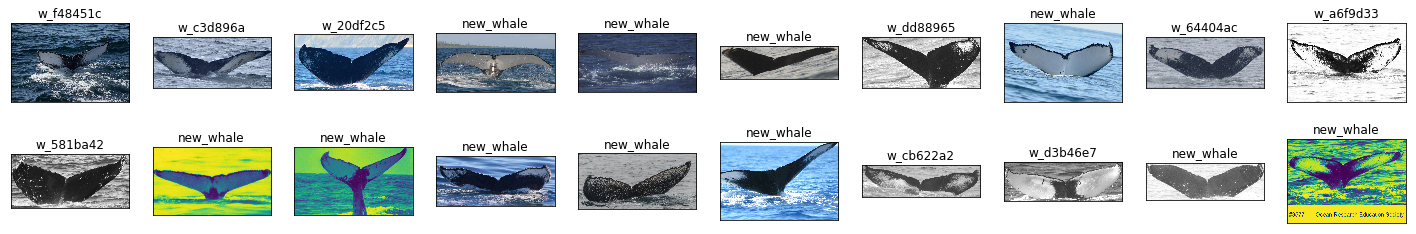

In [81]:
# Display a few examples
classes_to_display = 20

fig = plt.figure(figsize=(25, 4))
for idx in range(classes_to_display):
    img_name = df.Image.iloc[idx]
    img_label = df.Id.iloc[idx]
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = mpimg.imread(os.path.join(data_folder, 'train', img_name))
    plt.imshow(img)
    ax.set_title(img_label)    

In [82]:
# transforms
train_transforms = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomAffine(15, translate=None, scale=None, shear=15, resample=False, fillcolor=0),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])    
  ])

In [84]:
# get a sample of 20 whales
sample = np.random.choice(df['Image'],20)
file_path_sample = [os.path.join(img_train_path,whale) for whale in sample]

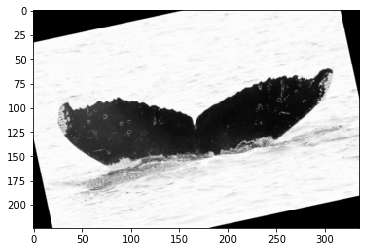

In [112]:
# apply transforms to sample images
imgs = [Image.open(whale) for whale in file_path_sample]
imgs_tensor = [train_transforms(whale) for whale in imgs]

# display a sample
img = imgs_tensor[0]
plt.imshow(img[0],cmap='gray')
plt.show()


In [113]:
# prepare the transformed images to be passed to model
train = df['Image_path'][:100] # prepare small sequence to test the process
imgs = [Image.open(whale) for whale in train]
imgs_tensor = [train_transforms(whale) for whale in imgs]

In [116]:
# create a df which excludes new_whale
exclude_new_whale = df['Id']!= 'new_whale'
exclude_new_whale_df = df[exclude_new_whale]
exclude_new_whale_df.Id.value_counts().head()

w_23a388d    73
w_9b5109b    65
w_9c506f6    62
w_0369a5c    61
w_700ebb4    57
Name: Id, dtype: int64